## Time Series Analysis (an attempt)

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from plotly.subplots import make_subplots

In [157]:
df = pd.read_csv('air_quality_weather_fires.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['site_id', 'date'])

In [158]:
state_daily = df.groupby(['state_name', 'date']).agg({
    'PM25': 'mean',
    'temperature_2m_mean': 'mean',
    'distance_to_fire_km': 'mean',
    'fires_within_50km': 'sum',
    'has_nearby_fire': 'sum',
    'site_id': 'count'    
}).reset_index()
state_daily = state_daily.rename({'site_id': 'n_sites'}, axis = 1)

In [159]:
daily_agg = df.groupby('date').agg({
    'PM25': 'mean',
    'temperature_2m_mean': 'mean',
    'distance_to_fire_km': 'mean',
    'fires_within_50km': 'sum',
    'has_nearby_fire': 'sum'
}).reset_index()

In [160]:
adfuller(daily_agg['PM25'])
# H0: Series has a unit root (non-stationary)
# H1: Series is stationary
# ADF Statistic: -1.445203
# P-value: 0.560424 --> Fail to reject H0: Series appears non-stationary (p >= 0.05)
# Should consider first differencing to achieve stationarity

(np.float64(-1.4452029107302986),
 np.float64(0.560423853573978),
 17,
 348,
 {'1%': np.float64(-3.4492815848836296),
  '5%': np.float64(-2.8698813715275406),
  '10%': np.float64(-2.5712138845950587)},
 np.float64(1045.8653461135004))

In [161]:
kpss(daily_agg['PM25'])
# H0: Series is stationary
# H1: Series has a unit root (non-stationary)
# KPSS Statistic: 0.189290
# P-value: 0.020016 --> Reject H0: Series appears non-stationary (p < 0.05)
# Should consider first differencing to achieve stationarity

C:\Users\annaj\AppData\Local\Temp\ipykernel_35828\3231861947.py:1: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




(np.float64(1.06848834799106),
 np.float64(0.01),
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [162]:
sample_site = df['site_id'].value_counts().index[0]
site_data = df[df['site_id'] == sample_site].sort_values('date')

adfuller(site_data['PM25'])
kpss(site_data['PM25'])

(np.float64(0.630689758001232),
 np.float64(0.01984638563625164),
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

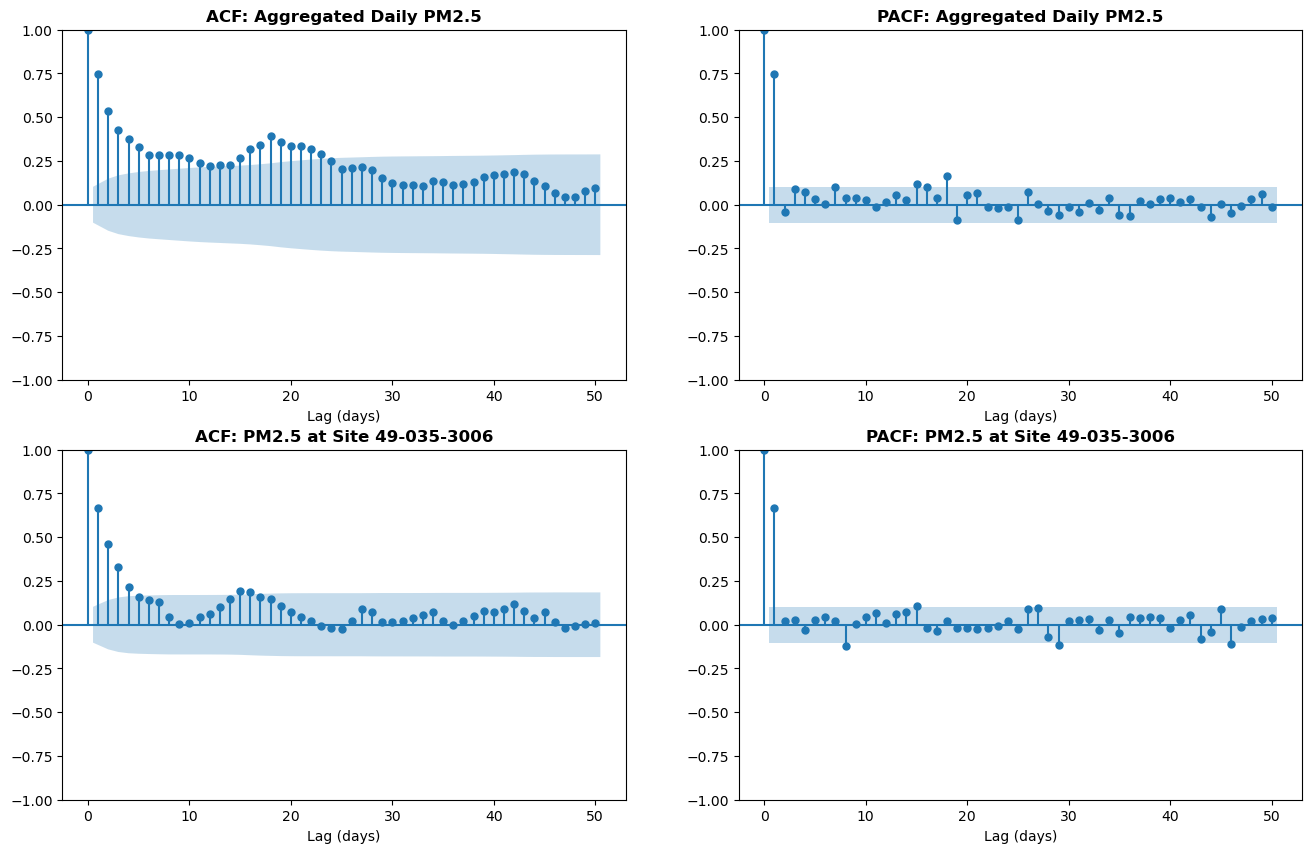

In [163]:
# Create ACF and PACF plots
fig = plt.figure(figsize=(16, 10))

# For aggregated daily PM2.5
ax1 = plt.subplot(2, 2, 1)
plot_acf(daily_agg['PM25'].dropna(), lags=50, ax=ax1, alpha=0.05)
ax1.set_title('ACF: Aggregated Daily PM2.5', fontsize=12, fontweight='bold')
ax1.set_xlabel('Lag (days)')

ax2 = plt.subplot(2, 2, 2)
plot_pacf(daily_agg['PM25'].dropna(), lags=50, ax=ax2, alpha=0.05, method='ywm')
ax2.set_title('PACF: Aggregated Daily PM2.5', fontsize=12, fontweight='bold')
ax2.set_xlabel('Lag (days)')

# For single site PM2.5
ax3 = plt.subplot(2, 2, 3)
plot_acf(site_data['PM25'].dropna(), lags=50, ax=ax3, alpha=0.05)
ax3.set_title(f'ACF: PM2.5 at Site {sample_site}', fontsize=12, fontweight='bold')
ax3.set_xlabel('Lag (days)')

ax4 = plt.subplot(2, 2, 4)
plot_pacf(site_data['PM25'].dropna(), lags=50, ax=ax4, alpha=0.05, method='ywm')
ax4.set_title(f'PACF: PM2.5 at Site {sample_site}', fontsize=12, fontweight='bold')
ax4.set_xlabel('Lag (days)')

plt.show()

# Strong autocorrelation detected -- lag 1 correlation is 0.74
# Suggests AR(p) processes

In [164]:
daily_agg['month'] = daily_agg['date'].dt.month
daily_agg['day_of_year'] = daily_agg['date'].dt.dayofyear

In [165]:
daily_agg_ts = daily_agg.set_index('date')
daily_agg_ts

,PM25,temperature_2m_mean,distance_to_fire_km,fires_within_50km,has_nearby_fire,month,day_of_year
date,,,,,,,
2024-01-01,14.625410,5.259016,208.440285,61,61,1,1
2024-01-02,8.645029,4.352632,125.361744,124,57,1,2
2024-01-03,8.626488,4.364286,118.894058,43,56,1,3
2024-01-04,6.861475,5.175410,332.513744,92,61,1,4
2024-01-05,7.730000,3.793333,149.878683,56,60,1,5
...,...,...,...,...,...,...,...
2024-12-27,9.960000,6.748889,211.766372,58,45,12,362
2024-12-28,8.750000,9.211111,288.167441,7,45,12,363
2024-12-29,8.077305,10.268085,263.148594,74,47,12,364


## Seasonal decomposition

In [166]:
# Additive decomposition
decomp_add_pm25 = seasonal_decompose(daily_agg_ts['PM25'], model = 'additive', period = 30)

print("\nAdditive Decomposition Components:")
print(f"Trend range: {decomp_add_pm25.trend.min():.2f} to {decomp_add_pm25.trend.max():.2f}")
print(f"Seasonal range: {decomp_add_pm25.seasonal.min():.2f} to {decomp_add_pm25.seasonal.max():.2f}")
print(f"Residual std: {decomp_add_pm25.resid.std():.2f}")


Additive Decomposition Components:
Trend range: 5.53 to 9.79
Seasonal range: -0.46 to 0.62
Residual std: 1.33


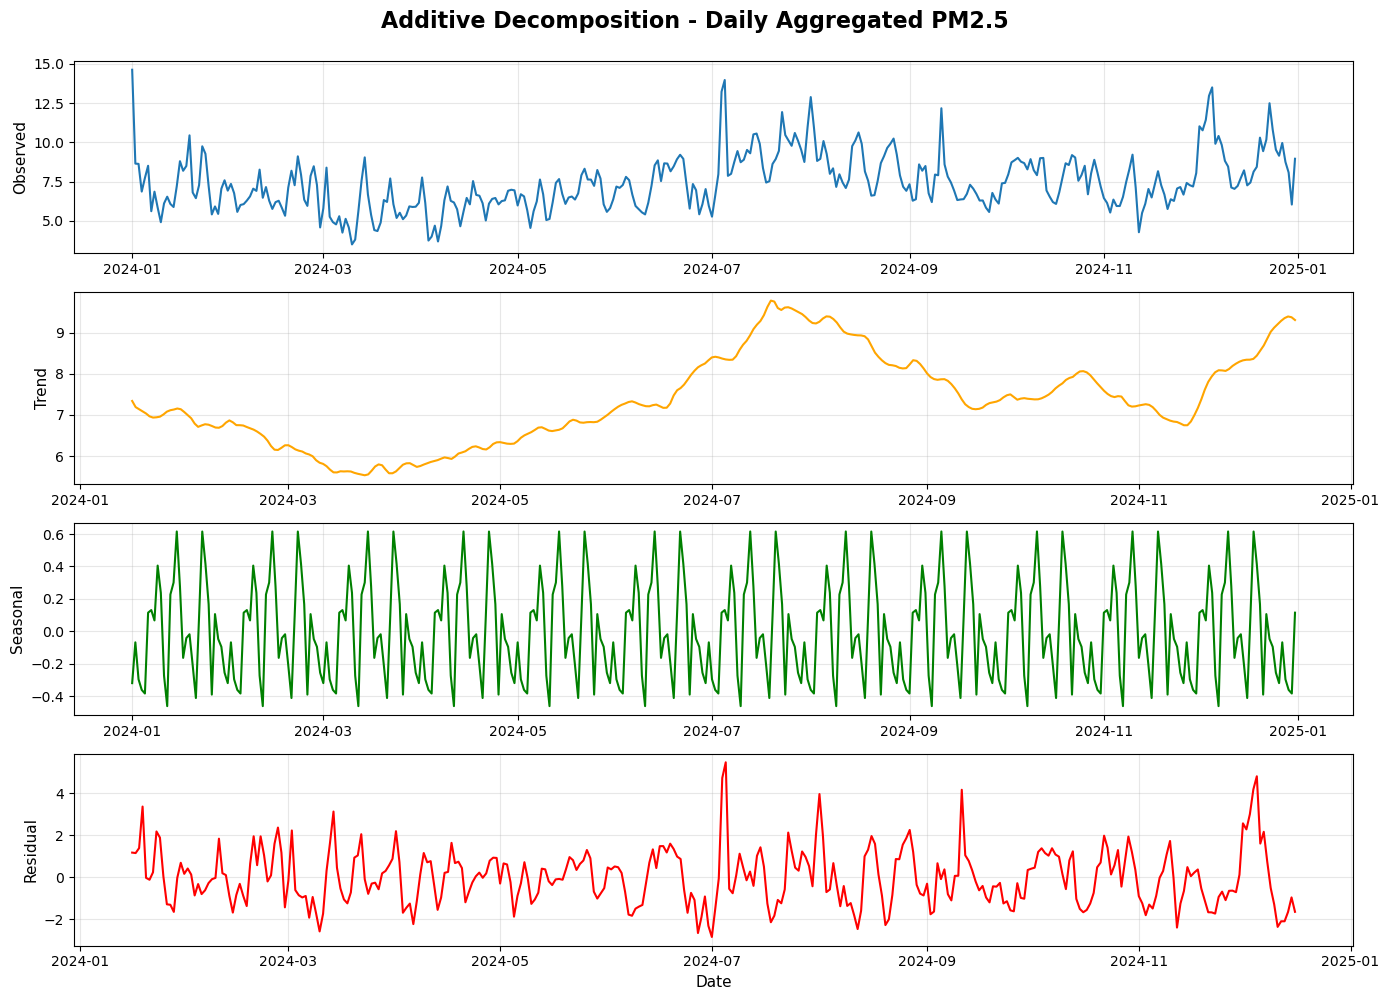

In [167]:
# Plot additive decomposition 
fig = plt.figure(figsize=(14, 10))
plt.suptitle('Additive Decomposition - Daily Aggregated PM2.5', fontsize=16, fontweight='bold', y=0.995)

plt.subplot(411)
plt.plot(daily_agg_ts.index, daily_agg_ts['PM25'], linewidth=1.5)
plt.ylabel('Observed', fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(412)
plt.plot(decomp_add_pm25.trend.index, decomp_add_pm25.trend, linewidth=1.5, color='orange')
plt.ylabel('Trend', fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(413)
plt.plot(decomp_add_pm25.seasonal.index, decomp_add_pm25.seasonal, linewidth=1.5, color='green')
plt.ylabel('Seasonal', fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(414)
plt.plot(decomp_add_pm25.resid.index, decomp_add_pm25.resid, linewidth=1.5, color='red')
plt.ylabel('Residual', fontsize=11)
plt.xlabel('Date', fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()

In [168]:
# Multiplicative decomposition
decomp_mult_pm25 = seasonal_decompose(daily_agg_ts['PM25'], model = 'multiplicative', period = 7)

print("\nMultiplicative Decomposition Components:")
print(f"Trend range: {decomp_mult_pm25.trend.min():.2f} to {decomp_mult_pm25.trend.max():.2f}")
print(f"Seasonal range: {decomp_mult_pm25.seasonal.min():.2f} to {decomp_mult_pm25.seasonal.max():.2f}")
print(f"Residual std: {decomp_mult_pm25.resid.std():.2f}")


Multiplicative Decomposition Components:
Trend range: 4.47 to 11.43
Seasonal range: 0.95 to 1.02
Residual std: 0.13


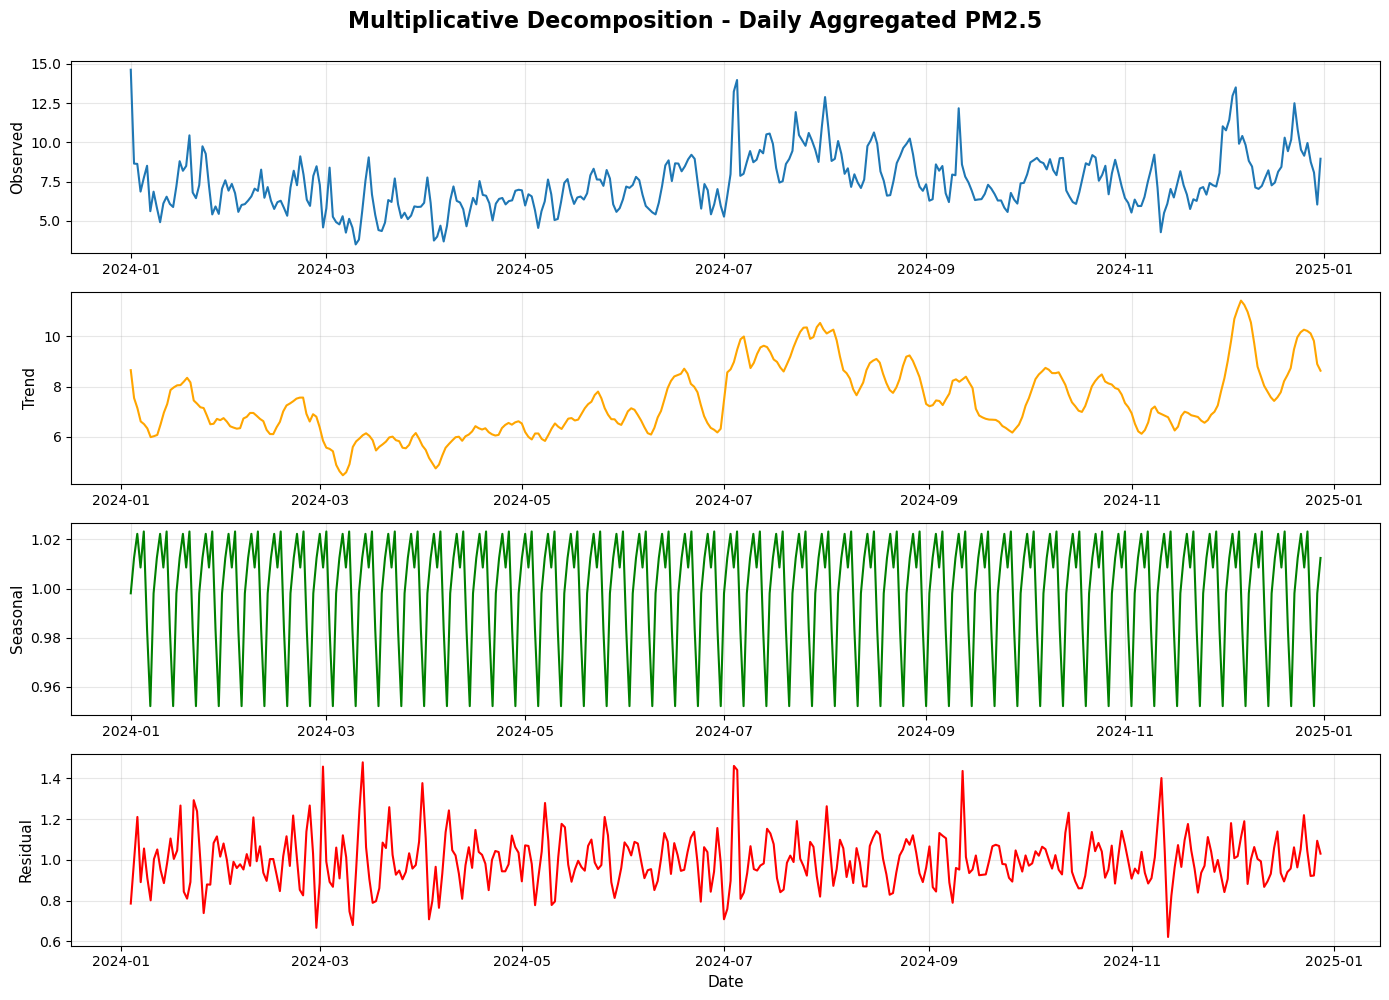

In [169]:
# Plot multiplicative decomposition
fig = plt.figure(figsize=(14, 10))
plt.suptitle('Multiplicative Decomposition - Daily Aggregated PM2.5', fontsize=16, fontweight='bold', y=0.995)

plt.subplot(411)
plt.plot(daily_agg_ts.index, daily_agg_ts['PM25'], linewidth=1.5)
plt.ylabel('Observed', fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(412)
plt.plot(decomp_mult_pm25.trend.index, decomp_mult_pm25.trend, linewidth=1.5, color='orange')
plt.ylabel('Trend', fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(413)
plt.plot(decomp_mult_pm25.seasonal.index, decomp_mult_pm25.seasonal, linewidth=1.5, color='green')
plt.ylabel('Seasonal', fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(414)
plt.plot(decomp_mult_pm25.resid.index, decomp_mult_pm25.resid, linewidth=1.5, color='red')
plt.ylabel('Residual', fontsize=11)
plt.xlabel('Date', fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()

# Seems to be more appropriate than additive decomposition due to lower residual std

## Scenario Analysis

In [170]:
# Create daily aggregated data
daily_agg = df.groupby('date').agg({
    'PM25': 'mean',
    'temperature_2m_mean': 'mean',
    'relative_humidity_2m_mean': 'mean',
    'wind_speed_10m_mean': 'mean',
    'precipitation_sum': 'sum',
    'distance_to_fire_km': 'mean',
    'fires_within_50km': 'sum',
    'fires_within_100km': 'sum',
    'has_nearby_fire': 'sum',
    'fire_brightness': 'mean',
    'fire_frp': 'mean'
}).reset_index()

# Create fire intensity indicator (lagged to test predictive power)
daily_agg['fire_intensity'] = daily_agg['fires_within_50km'] * daily_agg['fire_frp'].fillna(0)
daily_agg = daily_agg.fillna(method='ffill').fillna(0)

# Identify wildfire events (days with fires starting or intensifying)
daily_agg['fire_event'] = 0
daily_agg.loc[(daily_agg['fires_within_50km'] > 0) & 
              (daily_agg['fires_within_50km'].shift(1) == 0), 'fire_event'] = 1

# Also mark significant fire intensity increases
fire_change = daily_agg['fire_intensity'].diff()
threshold = fire_change.quantile(0.9)
daily_agg.loc[fire_change > threshold, 'fire_event'] = 1

fire_event_dates = daily_agg[daily_agg['fire_event'] == 1]['date'].tolist()
print(f"\nIdentified {len(fire_event_dates)} fire events")


Identified 38 fire events


C:\Users\annaj\AppData\Local\Temp\ipykernel_35828\40252823.py:18: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [171]:
# Create event study: PM2.5 evolution around fire events
window = 21  # 21 days (3 weeks): 7 days before, day of, 13 days after

event_study = []
for event_date in fire_event_dates:
    event_idx = daily_agg[daily_agg['date'] == event_date].index[0]
    
    # Get window around event
    start_idx = max(0, event_idx - 7)
    end_idx = min(len(daily_agg), event_idx + 14)
    
    if end_idx - start_idx >= 14:  # Ensure we have enough post-event data
        window_data = daily_agg.iloc[start_idx:end_idx].copy()
        window_data['days_from_event'] = range(-(event_idx - start_idx), end_idx - event_idx)
        window_data['event_id'] = event_date
        event_study.append(window_data)

event_study_df = pd.concat(event_study, ignore_index=True)

# Calculate average evolution
evolution = event_study_df.groupby('days_from_event').agg({
    'PM25': ['mean', 'std', 'count'],
    'temperature_2m_mean': 'mean',
    'wind_speed_10m_mean': 'mean',
    'relative_humidity_2m_mean': 'mean'
}).reset_index()

evolution.columns = ['days_from_event', 'PM25_mean', 'PM25_std', 'n_events', 
                     'temp_mean', 'wind_mean', 'humidity_mean']
evolution['PM25_se'] = evolution['PM25_std'] / np.sqrt(evolution['n_events'])

print("\nAverage PM2.5 evolution around fire events:")
print(evolution[['days_from_event', 'PM25_mean', 'PM25_std', 'n_events']])

# Calculate impact metrics
baseline_pm25 = evolution[evolution['days_from_event'] < 0]['PM25_mean'].mean()
peak_pm25 = evolution[evolution['days_from_event'] >= 0]['PM25_mean'].max()
peak_day = evolution[evolution['PM25_mean'] == peak_pm25]['days_from_event'].values[0]

print(f"\n--- Impact Metrics ---")
print(f"Baseline PM2.5 (pre-fire): {baseline_pm25:.2f} μg/m³")
print(f"Peak PM2.5 (post-fire): {peak_pm25:.2f} μg/m³")
print(f"Peak occurs at: Day {peak_day}")
print(f"Increase from baseline: {peak_pm25 - baseline_pm25:.2f} μg/m³ ({(peak_pm25/baseline_pm25 - 1)*100:.1f}%)")

# Calculate half-life (how long until returns to halfway between peak and baseline)
halfway = baseline_pm25 + (peak_pm25 - baseline_pm25) / 2
post_peak = evolution[evolution['days_from_event'] > peak_day]
if len(post_peak[post_peak['PM25_mean'] <= halfway]) > 0:
    halflife_day = post_peak[post_peak['PM25_mean'] <= halfway].iloc[0]['days_from_event']
    print(f"Half-life (return to midpoint): Day {halflife_day} ({halflife_day - peak_day:.0f} days after peak)")


Average PM2.5 evolution around fire events:
    days_from_event  PM25_mean  PM25_std  n_events
0                -7   7.290179  1.898463        37
1                -6   7.567679  1.848711        37
2                -5   7.669788  1.940644        37
3                -4   7.332085  1.735657        37
4                -3   7.218977  2.125112        38
5                -2   6.836113  1.726199        38
6                -1   7.099116  1.975995        38
7                 0   7.367683  1.474351        38
8                 1   7.583407  1.463168        38
9                 2   8.004649  1.811283        38
10                3   7.890932  1.798745        38
11                4   7.545051  1.399653        38
12                5   7.307117  1.458448        38
13                6   7.310466  1.711633        38
14                7   7.336447  1.717577        38
15                8   7.507244  1.816442        38
16                9   7.287580  1.828530        38
17               10   7.262487  1.579

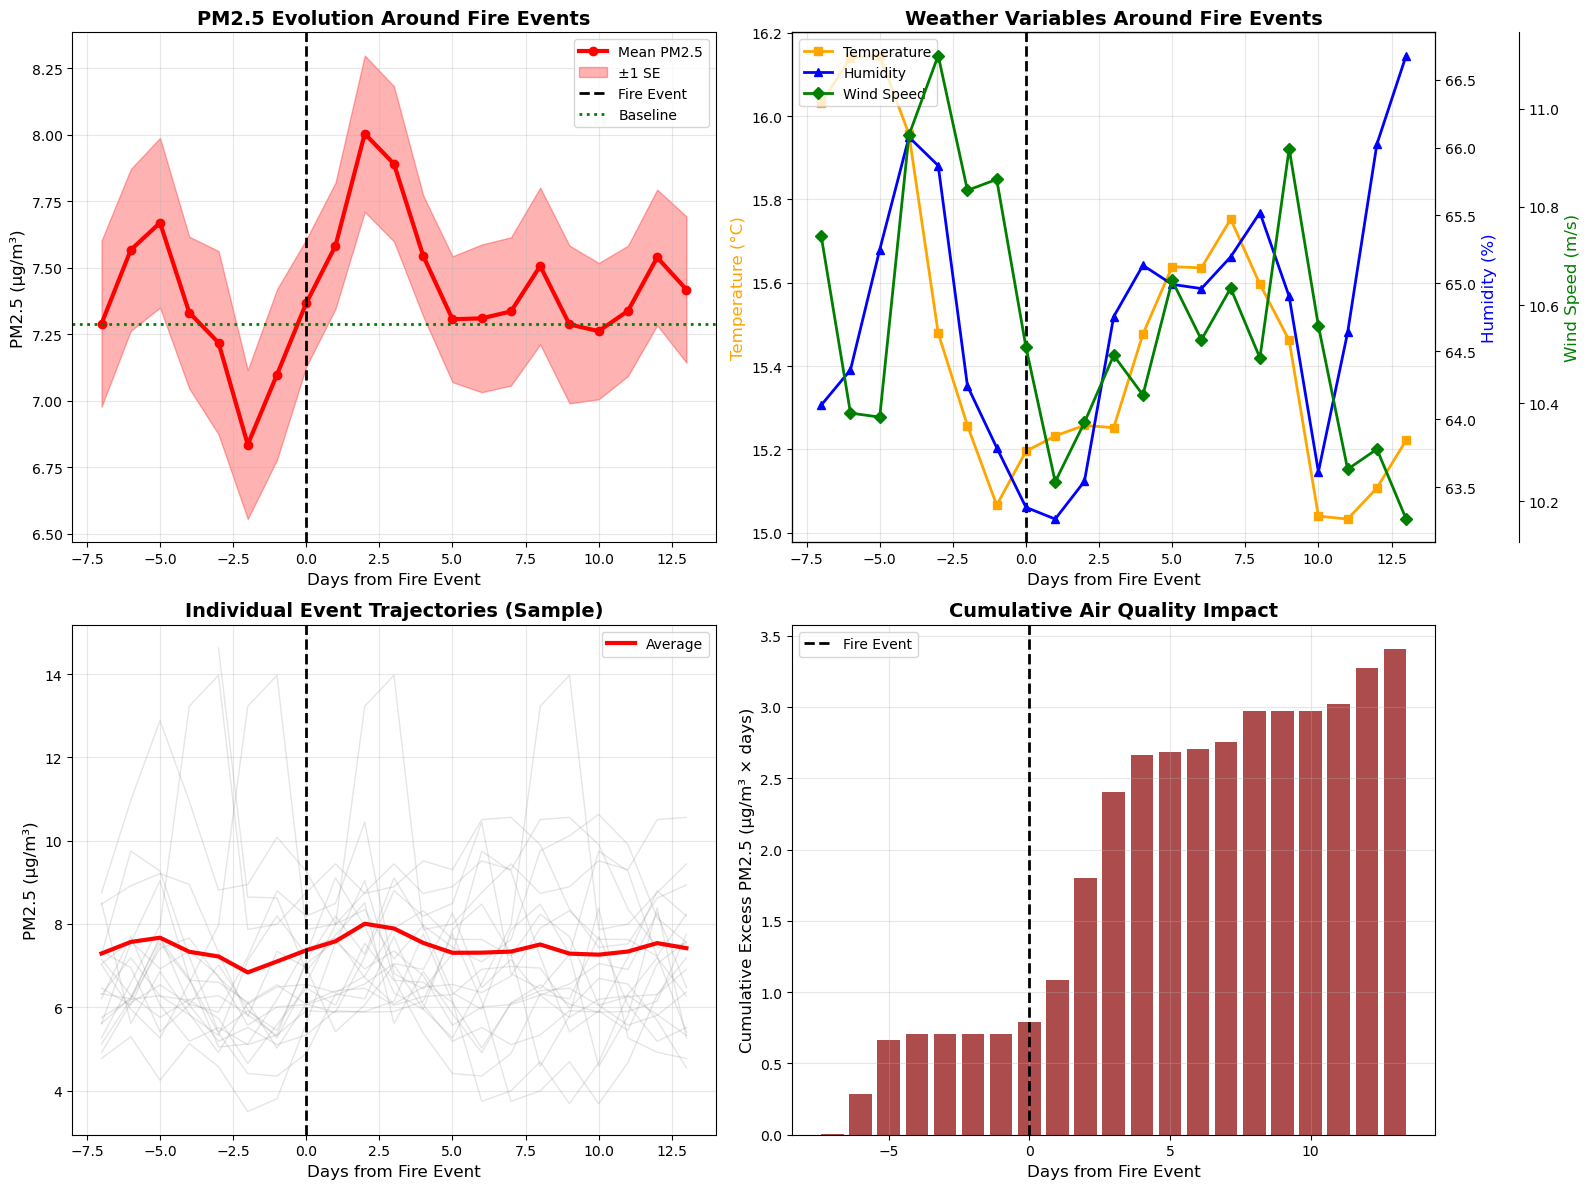

In [172]:
# Visualize scenario analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: PM2.5 Evolution
ax1 = axes[0, 0]
ax1.plot(evolution['days_from_event'], evolution['PM25_mean'], 
         linewidth=3, marker='o', markersize=6, color='red', label='Mean PM2.5')
ax1.fill_between(evolution['days_from_event'], 
                  evolution['PM25_mean'] - evolution['PM25_se'],
                  evolution['PM25_mean'] + evolution['PM25_se'],
                  alpha=0.3, color='red', label='±1 SE')
ax1.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Fire Event')
ax1.axhline(y=baseline_pm25, color='green', linestyle=':', linewidth=2, label='Baseline')
ax1.set_xlabel('Days from Fire Event', fontsize=12)
ax1.set_ylabel('PM2.5 (μg/m³)', fontsize=12)
ax1.set_title('PM2.5 Evolution Around Fire Events', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Weather Variables Evolution
ax2 = axes[0, 1]
ax2_temp = ax2.twinx()
ax2_wind = ax2.twinx()
ax2_wind.spines['right'].set_position(('outward', 60))

l1 = ax2.plot(evolution['days_from_event'], evolution['temp_mean'], 
              linewidth=2, marker='s', color='orange', label='Temperature')
l2 = ax2_temp.plot(evolution['days_from_event'], evolution['humidity_mean'], 
                   linewidth=2, marker='^', color='blue', label='Humidity')
l3 = ax2_wind.plot(evolution['days_from_event'], evolution['wind_mean'], 
                   linewidth=2, marker='D', color='green', label='Wind Speed')

ax2.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax2.set_xlabel('Days from Fire Event', fontsize=12)
ax2.set_ylabel('Temperature (°C)', fontsize=12, color='orange')
ax2_temp.set_ylabel('Humidity (%)', fontsize=12, color='blue')
ax2_wind.set_ylabel('Wind Speed (m/s)', fontsize=12, color='green')
ax2.set_title('Weather Variables Around Fire Events', fontsize=14, fontweight='bold')

lns = l1 + l2 + l3
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Distribution of individual event responses
ax3 = axes[1, 0]
for event_id in event_study_df['event_id'].unique()[:20]:  # Plot first 20 events
    event_data = event_study_df[event_study_df['event_id'] == event_id]
    ax3.plot(event_data['days_from_event'], event_data['PM25'], 
             alpha=0.2, linewidth=1, color='gray')
ax3.plot(evolution['days_from_event'], evolution['PM25_mean'], 
         linewidth=3, color='red', label='Average')
ax3.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax3.set_xlabel('Days from Fire Event', fontsize=12)
ax3.set_ylabel('PM2.5 (μg/m³)', fontsize=12)
ax3.set_title('Individual Event Trajectories (Sample)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Cumulative impact
ax4 = axes[1, 1]
evolution['cumulative_excess'] = (evolution['PM25_mean'] - baseline_pm25).clip(lower=0).cumsum()
ax4.bar(evolution['days_from_event'], evolution['cumulative_excess'], 
        alpha=0.7, color='darkred')
ax4.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Fire Event')
ax4.set_xlabel('Days from Fire Event', fontsize=12)
ax4.set_ylabel('Cumulative Excess PM2.5 (μg/m³ × days)', fontsize=12)
ax4.set_title('Cumulative Air Quality Impact', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()

## Examining how wind speed moderates fire effect

In [173]:
# Re-map labels to fire distance categories
label_map = {'very_close': 'Fire <50km',
             'close': 'Fire <50km',
             'moderate': 'Fire 50-100km',
             'far': 'Far 100km+'}
df.replace({"fire_distance_category": label_map}, inplace=True)

df['wind_category'] = pd.cut(df['wind_speed_10m_mean'], 
                              bins=[0, 8, 12, np.inf],
                              labels=['Low wind (<8 km/h)', 
                                      'Moderate wind (8-12)', 
                                      'High wind (>12)'])


In [174]:
# Aggregate daily across all sites
daily_data = df.groupby(['date', 'fire_distance_category', 'wind_category']).agg({
    'PM25': 'mean',
    'temperature_2m_max': 'mean',
    'wind_speed_10m_mean': 'mean'
}).reset_index()

C:\Users\annaj\AppData\Local\Temp\ipykernel_35828\2537272549.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [175]:
# Calculate 7-day rolling averages
daily_data['PM25_smooth'] = np.nan

fire_categories = ['Fire <50km', 'Fire 50-100km', 'Far 100km+']
wind_categories = ['Low wind (<8 km/h)', 'Moderate wind (8-12)', 'High wind (>12)']

for fire_cat in fire_categories:
    for wind_cat in wind_categories:
        mask = (daily_data['fire_distance_category'] == fire_cat) & \
               (daily_data['wind_category'] == wind_cat)
        
        if mask.sum() > 0:
            subset_idx = daily_data[mask].index
            subset_sorted = daily_data.loc[subset_idx].sort_values('date')
            rolled = subset_sorted['PM25'].rolling(window=7, center=True, min_periods=1).mean()
            daily_data.loc[subset_idx, 'PM25_smooth'] = rolled.values


In [178]:
# Create figure
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=(
        'PM2.5 Levels by Fire Proximity and Wind Speed (7-day rolling average)',
        'Wind Speed Moderation Effect on Fire-Air Quality Relationship'
    ),
    vertical_spacing=0.15,
    row_heights=[0.6, 0.4]
)

# Color schemes
colors_fire = {
    'Fire <50km': '#d62728',
    'Fire 50-100km': '#ff7f0e',
    'Far 100km+': '#2ca02c'
}

colors_wind = {
    'Low wind (<8 km/h)': 'rgba(255,0,0,0.7)', 
    'Moderate wind (8-12)': 'rgba(255,165,0,0.7)', 
    'High wind (>12)': 'rgba(0,128,255,0.7)'
}


In [179]:
# Plot time series
for fire_cat in fire_categories:
    for wind_cat in wind_categories:
        # Filter data
        subset = daily_data[
            (daily_data['fire_distance_category'] == fire_cat) & 
            (daily_data['wind_category'] == wind_cat)
        ].copy()
        
        if len(subset) > 0:
            # Remove NaN values - CORRECTED SYNTAX
            subset_clean = subset[subset['PM25_smooth'].notna()].copy()
            
            if len(subset_clean) > 0:
                # Line style based on wind category
                if wind_cat == 'High wind (>12)':
                    line_style = 'solid'
                elif wind_cat == 'Moderate wind (8-12)':
                    line_style = 'dash'
                else:
                    line_style = 'dot'
                
                fig.add_trace(
                    go.Scatter(
                        x=subset_clean['date'],
                        y=subset_clean['PM25_smooth'],
                        name=f'{fire_cat} - {wind_cat}',
                        line=dict(
                            color=colors_fire[fire_cat],
                            dash=line_style,
                            width=2
                        ),
                        mode='lines',
                        legendgroup=fire_cat,
                        showlegend=True
                    ),
                    row=1, col=1
                )

In [180]:
# Plot box plot
box_data = df[df['distance_to_fire_km'] < 100].copy()

for wind_cat in wind_categories:
    for fire_cat in ['Fire <50km', 'Fire 50-100km']:
        subset = box_data[
            (box_data['fire_distance_category'] == fire_cat) & 
            (box_data['wind_category'] == wind_cat)
        ]
        
        if len(subset) > 0:
            fig.add_trace(
                go.Box(
                    y=subset['PM25'],
                    name=f'{fire_cat}<br>{wind_cat}',
                    marker_color=colors_wind[wind_cat],
                    boxmean='sd',
                    showlegend=False
                ),
                row=2, col=1
            )

In [181]:
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_xaxes(title_text="Fire Proximity & Wind Condition", row=2, col=1, tickangle=45)
fig.update_yaxes(title_text="PM2.5 (μg/m³)", row=1, col=1)
fig.update_yaxes(title_text="PM2.5 (μg/m³)", row=2, col=1)

fig.update_layout(
    height=900,
    title_text="<b>How Wind Speed Moderates Wildfire Impacts on Air Quality</b><br>" +
               "<sub>Higher wind speeds (solid lines) reduce PM2.5 levels during fire events by dispersing smoke</sub>",
    title_font_size=18,
    hovermode='x unified',
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.02,
        font=dict(size=9)
    )
)

This demonstrates that higher wind speeds moderate wildfire impacts by dispersing smoke. On low wind days, particulate matter settles in the air, leading to worse air quality. Red lines which indicate closer fires show worse air quality, which is exacerbated with low winds. We see in the box plots too that blue boxes (high wind) show consistently lower PM2.5 concentrations than low wind.